## 1. Import Library & Resources

In [27]:
# Install library yang diperlukan
!pip install roboflow tensorflow scikit-learn numpy pandas matplotlib opencv-python

# Import library
from roboflow import Roboflow
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from google.colab import files
import tensorflow as tf

## 2. Unduh Dataset

In [28]:
# Unduh dataset dari Roboflow
rf = Roboflow(api_key="WrMilUVQGzcdY3bTyCei")
project = rf.workspace("skripsi-aji").project("klasifikasi-sampah-organik-dan-anorganik")
version = project.version(35)
dataset = version.download("yolov11")

# Cek struktur folder dataset
base_path = dataset.location
print("Struktur dataset:")
print(os.listdir(base_path))

# Path ke folder train, valid, dan test
train_path = os.path.join(base_path, 'train', 'images')
valid_path = os.path.join(base_path, 'valid', 'images')
test_path = os.path.join(base_path, 'test', 'images')

print(f"Train images: {len(os.listdir(train_path)) if os.path.exists(train_path) else 0}")
print(f"Valid images: {len(os.listdir(valid_path)) if os.path.exists(valid_path) else 0}")
print(f"Test images: {len(os.listdir(test_path)) if os.path.exists(test_path) else 0}")

loading Roboflow workspace...
loading Roboflow project...
Struktur dataset:
['README.roboflow.txt', 'valid', 'train', 'data.yaml', 'test', 'README.dataset.txt']
Train images: 20391
Valid images: 473
Test images: 307


## 3. Preprocessing Dataset

In [29]:
# Fungsi untuk preprocessing gambar
def preprocess_image(image_path, target_size=(64, 64)):
    img = cv2.imread(image_path)
    if img is None:  # Cek jika gambar gagal dibaca
        return None
    img = cv2.resize(img, target_size)  # Resize ke 64x64
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ubah ke RGB
    img = img.flatten()  # Ubah ke vektor 1D
    img = img / 255.0  # Normalisasi ke [0, 1]
    return img

# Path ke folder train dan valid
train_images_path = os.path.join(base_path, 'train', 'images')
train_labels_path = os.path.join(base_path, 'train', 'labels')
valid_images_path = os.path.join(base_path, 'valid', 'images')
valid_labels_path = os.path.join(base_path, 'valid', 'labels')

# Membaca data dan label
X = []  # Data gambar
y = []  # Label (0: anorganik, 1: organik)

# Fungsi untuk membaca label dari file anotasi
def get_label_from_annotation(label_file_path):
    with open(label_file_path, 'r') as f:
        lines = f.readlines()
        if lines:  # Ambil label dari baris pertama
            class_id = int(lines[0].split()[0])  # Class ID ada di kolom pertama
            return class_id  # 0 untuk anorganik, 1 untuk organik
    return None

# Proses folder train
for img_file in os.listdir(train_images_path):
    if img_file.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(train_images_path, img_file)
        label_file = os.path.join(train_labels_path, img_file.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt'))
        if os.path.exists(label_file):
            img_data = preprocess_image(img_path)
            if img_data is not None:
                label = get_label_from_annotation(label_file)
                if label is not None:
                    X.append(img_data)
                    y.append(label)

# Proses folder valid
for img_file in os.listdir(valid_images_path):
    if img_file.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(valid_images_path, img_file)
        label_file = os.path.join(valid_labels_path, img_file.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt'))
        if os.path.exists(label_file):
            img_data = preprocess_image(img_path)
            if img_data is not None:
                label = get_label_from_annotation(label_file)
                if label is not None:
                    X.append(img_data)
                    y.append(label)

# Konversi ke array numpy
X = np.array(X)
y = np.array(y)

# Cek jumlah data
print(f"Jumlah sampel X: {len(X)}")
print(f"Jumlah sampel y: {len(y)}")

# Split data untuk train dan test
if len(X) > 0 and len(y) > 0 and len(X) == len(y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Jumlah data train: {len(X_train)}")
    print(f"Jumlah data test: {len(X_test)}")
else:
    print("Error: Data X dan y kosong atau tidak sesuai jumlahnya!")

Jumlah sampel X: 20810
Jumlah sampel y: 20810
Jumlah data train: 16648
Jumlah data test: 4162


## 4. Visualisasi Data

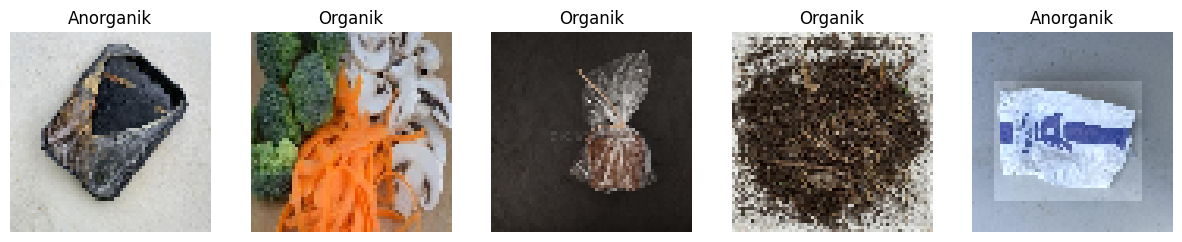

In [30]:
# Visualisasi contoh gambar
def show_sample_images(X, y, num_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        img = X[i].reshape(64, 64, 3)  # Reshape ke bentuk gambar 64x64 RGB
        plt.imshow(img)
        plt.title('Anorganik' if y[i] == 0 else 'Organik')
        plt.axis('off')
    plt.show()

# Tampilkan 5 sampel dari data train
show_sample_images(X_train, y_train)

## 5. Modelling dengan Neural Network

In [31]:
# Definisikan model neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(64 * 64 * 3,)),  # Input sesuai vektor flatten (12288)
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Output biner (0: Anorganik, 1: Organik)
])

# Kompilasi model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Tampilkan ringkasan model
model.summary()

# Latih model dengan epoch maksimal 15
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=15,
                    batch_size=32,
                    verbose=1)

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │       1,572,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,581,313 (6.03 MB)

 Trainable params: 1,581,313 (6.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
521/521 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7365 - loss: 0.6605 - val_accuracy: 0.8061 - val_loss: 0.4449
Epoch 2/15
521/521 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7941 - loss: 0.4650 - val_accuracy: 0.8044 - val_loss: 0.4372
Epoch 3/15
521/521 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7993 - loss: 0.4425 - val_accuracy: 0.8027 - val_loss: 0.4461
Epoch 4/15
521/521 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8057 - loss: 0.4399 - val_accuracy: 0.8109 - val_loss: 0.4277
Epoch 5/15
521/521 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8186 - loss: 0.4183 - val_accuracy: 0.8090 - val_loss: 0.4263
Epoch 6/15
521/521 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8127 - loss: 0.4236 - val_accuracy: 0.7970 - val_loss: 0.4436
Epoch 7/15
521/521 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8122 - loss: 0.4254 - val_accuracy: 0.7919 - val_loss: 0.4735
Epoch 8/15
521/521 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8106 - loss: 0.4220 - val_accuracy: 0.

In [32]:
# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi pada data test: {accuracy * 100:.2f}%")

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8143 - loss: 0.3929
Akurasi pada data test: 82.27%


In [33]:
# Simpan model
model.save('nn_sampah_classifier.h5')

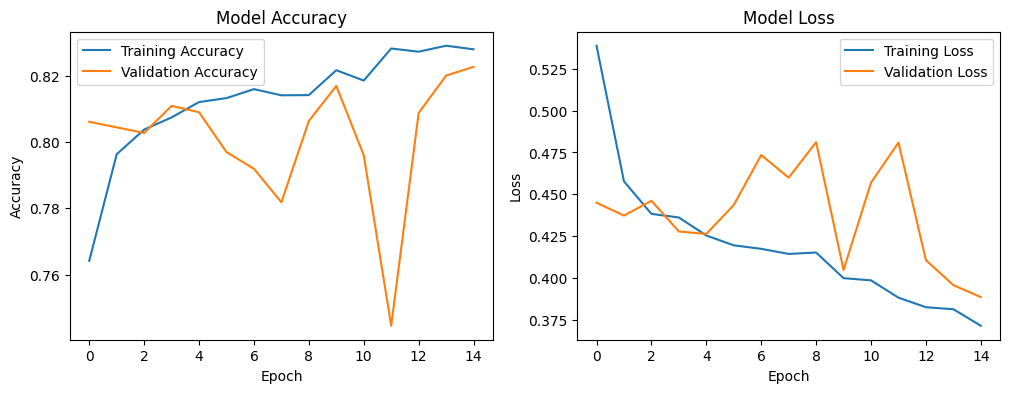

In [34]:
# Plot akurasi dan loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 6. Testing

Unggah gambar untuk pengujian:


Saving 1.jpeg to 1 (3).jpeg
Prediksi untuk 1 (3).jpeg: Kelas Organik dengan probabilitas 0.83


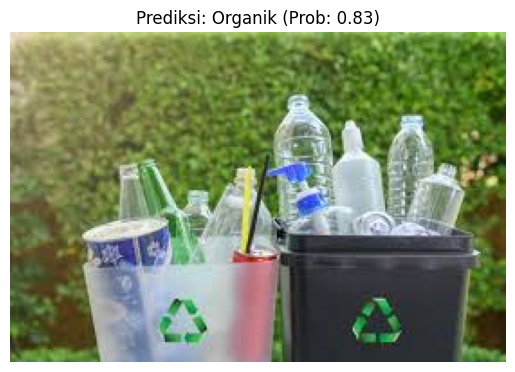

In [36]:
# Fungsi prediksi untuk neural network
def predict_image_nn(image_path, model, target_size=(64, 64)):
    img = preprocess_image(image_path, target_size)
    if img is None:
        return "Error: Gambar tidak dapat dibaca", None
    img = img.reshape(1, -1)  # Reshape untuk prediksi
    prediction = model.predict(img, verbose=0)[0][0]  # Probabilitas kelas 1 (Organik)
    predicted_class = 'Anorganik' if prediction < 0.5 else 'Organik'
    return predicted_class, prediction

# Testing dengan upload gambar
print("Unggah gambar untuk pengujian:")
uploaded = files.upload()
uploaded_image_file = list(uploaded.keys())[0]
test_image_path = uploaded_image_file

# Lakukan prediksi
predicted_class, result = predict_image_nn(test_image_path, model)
print(f"Prediksi untuk {uploaded_image_file}: Kelas {predicted_class} dengan probabilitas {result:.2f}")

# Tampilkan gambar
img = cv2.imread(test_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title(f"Prediksi: {predicted_class} (Prob: {result:.2f})")
plt.axis('off')
plt.show()